In [1]:
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

In [2]:
import numpy as np

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader

from scipy import stats
from scipy.stats import norminvgauss, norm, pareto, levy_stable

import random

import torchvision

import tqdm
from tqdm import trange

import pandas as pd
import csv


from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def get_accuracy(model, dataloader, device):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)


class Monitor:
    def __init__(self):
        if hasattr(tqdm.tqdm, '_instances'):
            [*map(tqdm.tqdm._decr_instances, list(tqdm.tqdm._instances))]

        self.learning_curve = []
        self.train_accuracy_curve = []
        self.val_accuracy_curve = []
        self.best_val_accuracy = 0
        self.best_val_epoch = 0

    def add_loss_value(self, value):
        self.learning_curve.append(value)

    def add_train_accuracy_value(self, value):
        self.train_accuracy_curve.append(value)

    def add_val_accuracy_value(self, value):
        self.val_accuracy_curve.append(value)

        if value > self.best_val_accuracy:
            self.best_val_accuracy = value
            self.best_val_epoch = len(self.val_accuracy_curve)

    def show(self):
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))
        axes[0].set_title('Loss')
        axes[0].plot(self.learning_curve)

        last_train_accuracy = self.train_accuracy_curve[-1]
        last_val_accuracy = self.val_accuracy_curve[-1]
        best_val_accuracy = self.best_val_accuracy
        best_val_accuracy = self.best_val_accuracy

        axes[1].set_title(f'Train {last_train_accuracy:.4f}, val {last_val_accuracy:.4f}, '
                          f'max val {self.best_val_accuracy:.4f} at {self.best_val_epoch}')
        axes[1].plot(self.train_accuracy_curve)
        axes[1].plot(self.val_accuracy_curve)

        plt.tight_layout()
        plt.show()


def set_random_seeds(seed_value=0, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [4]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

## 1 Fully-connected network (FCN) on the MNIST 

In [5]:
class FullyConnected(nn.Module):

    def __init__(self, input_dim=28*28, width=16, depth=3, num_classes=10):
        super(FullyConnected, self).__init__()
        self.input_dim = input_dim
        self.width = width
        self.depth = depth
        self.num_classes = num_classes

        layers = self.get_layers()

        self.fcn = nn.Sequential(
            nn.Linear(self.input_dim, self.width, bias=False),
            nn.ReLU(inplace=True),
            *layers,
            nn.Linear(self.width, self.num_classes, bias=False),
        )

    def get_layers(self):

        layers = []
        for _ in range(self.depth - 2):
            layers.append(nn.Linear(self.width, self.width, bias=False))
            layers.append(nn.ReLU())
        return layers

    def forward(self, x):
        r"""
        Parameters
        ----------
        x : torch.Tensor
            of shape [batch_size, channels_n, height, width]
        
        Returns
        -------
        y : torch.Tensor
            of shape [batch_size, classes_n]
        """
        x = x.view(x.size(0), self.input_dim)
        x = self.fcn(x)
        return x

In [6]:
# we choose the device that we will work on --- GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/home/dimitry/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# 2 Training procedure

In [7]:
# Method for gathering gradients from NN
def get_grads(model):
    grads = []
    for param in model.parameters():
        if param.requires_grad == True:
            grads.append(param.grad.view(-1))
    grad_flat = torch.cat(grads)
    return grad_flat

def save_grads(model, optimizer, loss_function, train_loader, device, filepath, log_num_iter):
    with open(filepath + f'_epoch_logiter_{log_num_iter}.npy', 'ab') as file:

        for model_input_gr, target_gr in train_loader:
            model_input_gr = model_input_gr.to(device)
            target_gr = target_gr.to(device)
            model_output_gr = model(model_input_gr)
            loss_gr= loss_function(model_output_gr, target_gr)
            optimizer.zero_grad()
            #calc the gradient on batch
            loss_gr.backward()
              #store the gradient
              #Full gradient will be calculated later, 
              #as mean of the saved gradients of all batches 
            grad = get_grads(model).cpu()
            np.save(file, grad.numpy())


def train(model, optimizer, loss_function, train_loader, val_loader, device, filepath, epochs=1, plot_each=1, log_iter=100):
    # send the model to that device
    model = model.to(device)
    monitor = Monitor()
    
    log_num_iter=0
    for epoch in trange(epochs):
        model.train()
        
        for iter, (model_input, target)  in enumerate(train_loader):
            # send data to device
            model_input = model_input.to(device)
            target = target.to(device)
            # calculate outputs and loss
            model_output = model(model_input)
            loss = loss_function(model_output, target)
            # update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            # do some visualization
            monitor.add_loss_value(loss.item())
            #calculate grad on iteration
            if (iter+1) % log_iter == 0:
                log_num_iter+=1
                with open(filepath + f'logiter_{100*log_num_iter}.npy', 'ab') as file:
                    for model_input_gr, target_gr in train_loader:
                        model_input_gr = model_input_gr.to(device)
                        target_gr = target_gr.to(device)
                        model_output_gr = model(model_input_gr)
                        loss_gr= loss_function(model_output_gr, target_gr)
                        optimizer.zero_grad()
                        #calc the gradient on batch
                        loss_gr.backward()
                        #store the gradient
                        #Full gradient will be calculated later, 
                        #as mean of the saved gradients of all batches 
                        grad = get_grads(model).cpu()
                        np.save(file, grad.numpy())
        # evaluate the model
        model.eval()
        train_accuracy = get_accuracy(model, train_loader, device)
        val_accuracy = get_accuracy(model, val_loader, device)
        monitor.add_train_accuracy_value(train_accuracy)
        monitor.add_val_accuracy_value(val_accuracy)
        if epoch % plot_each == 0:
            monitor.show()

    return model


# 3 SGN and Alpha calculating

In [8]:
def alpha_estimator(x):

    K = len(x)
    list1 = np.array([d for d in range (1, K // 2 + 1) if K % d == 0] + [K])
    difference = abs(np.sqrt(K) - list1)
    K_1 = list1[np.argmin(difference)]
    K_2 = int(K/K_1)
    y = np.zeros(K_2)
    for i in range(K_2):
        y[i] = sum((x[j + (i-1) * K_1] for j in range(K_1)))

    return 1 / ((1/np.log(K_1)) * ((1/K_2) * sum(np.log(abs(y))) - (1/len(x)) * sum(np.log(abs(x)))))

# calculates mean alphas for every iteration and store them. Also store sgn samples.
def sgn_data_research(filepath, n_batches, epochs, log_iter, n_params):    
    total_iterations = epochs * n_batches / log_iter
    alphas = []
    sgn_storage = []
    for iteration in range(log_iter, int(total_iterations * log_iter) + 1, log_iter):
        batch_grads = []
        with open(filepath + f'logiter_{iteration}.npy', 'rb') as file:
            for _ in range(n_batches):
                batch_grads.append(np.load(file))
                
        # delete batch_grads file to avoid ssd memory overflow         
        if os.path.isfile(filepath + f'logiter_{iteration}.npy'): 
            os.remove(filepath + f'logiter_{iteration}.npy') 
        else: 
            print(filepath + f"logiter_{iteration}.npy doesn't exists!")
        
        sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / n_batches).T
        del(batch_grads)
        # delete non-active neuron's sgn (zero-vectors sgn)
        sgn = sgn[~np.any(sgn == 0, axis=1), :]
        alphas.append(np.apply_along_axis(alpha_estimator, axis=1, arr=sgn))
        sgn_storage.append(sgn[[i for i in range(0, sgn.shape[0], 400)]])
        del(sgn)
    
    sgn_storage = np.array(sgn_storage)
    with open(filepath + 'sgn_samples.npy', 'wb') as file:
        np.save(file, sgn_storage)
        
    print('SGN samples are saved!')
    del(sgn_storage)
    
    mean_alphas = []
    for alpha_vec in alphas:
        mean_alphas.append(alpha_vec.mean())
    with open(filepath + 'mean_alphas.npy', 'wb') as file:
        np.save(file, np.array(mean_alphas))
        
    print("alpha's estimations are saved!")    
    del(alphas)
    del(mean_alphas)
    

# 4 Experiment evaluation method


In [9]:
# function launch whole experiment
def experimetn_eval(filepath, model_hyp_params, train_data, val_data, input_dim, num_classes, log_iter, data_len):
    # calculating some params for experiment eval
    n_params = input_dim * model_hyp_params['width'] + (model_hyp_params['depth'] - 2) * model_hyp_params['width']**2 + model_hyp_params['width'] * num_classes
    n_batches = data_len // model_hyp_params['batch_size']
    total_iterations = model_hyp_params['epochs'] * (data_len / model_hyp_params['batch_size']) / log_iter
    
    # creating folders and filepaths for data aand picture storage
    exp_setup = 'width_' + str(model_hyp_params['width']) + '_depth_' + str(model_hyp_params['depth']) + '_batch_' + str(model_hyp_params['batch_size'])
    os.mkdir(filepath + exp_setup)
    filepath = filepath + exp_setup + '/'
    
    print(f'Total iterations: {total_iterations}')
    
    # trainig model. storing gradients 
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=model_hyp_params['batch_size'], num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=model_hyp_params['batch_size'], num_workers=2)
    
    model = FullyConnected(input_dim=input_dim, width=model_hyp_params['width'], depth=model_hyp_params['depth'], num_classes=num_classes)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=model_hyp_params['lr'])
    mini_batch_model = train(model, optimizer, loss_function,
                                 train_loader, val_loader,
                                 device, filepath=filepath, epochs=model_hyp_params['epochs'],
                                 log_iter=log_iter)
    # calculating sgn and alpha's estimation
    sgn_data_research(filepath, n_batches, model_hyp_params['epochs'], log_iter, n_params)

# 5 Experiment

In [10]:
from sklearn.model_selection import ParameterGrid
from torchvision.datasets import MNIST

mnist_train = MNIST(root = './', train=True, download=True, 
                    transform=torchvision.transforms.ToTensor())
mnist_val = MNIST(root = './', train=False, download=True, 
                  transform=torchvision.transforms.ToTensor())

MNIST_train_len = mnist_train.targets.shape[0]

set_random_seeds(device=device)

# write your filepath to store all data
filepath = 'exp_storage/'

param_grid = {'batch_size': [50, 100, 150, 200, 300],
              'width': [16, 32, 64],
              'depth': [2, 3, 4, 5],
              'lr': [1e-1],
              'epochs': [10]}


input_dim = 28*28
num_classes = 10
log_iter = 100

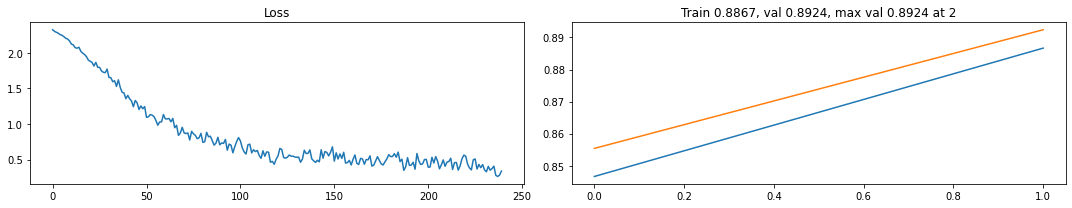

100%|██████████| 2/2 [00:18<00:00,  9.24s/it]


11389
11383
SGN samples are saved!
alpha's estimations are saved!


In [11]:
for model_params in ParameterGrid(param_grid):
    experimetn_eval(filepath=filepath, 
                    model_hyp_params=model_params,
                    train_data=mnist_train, val_data=mnist_val, 
                    input_dim=input_dim, 
                    num_classes=num_classes, 
                    log_iter=log_iter, 
                    data_len=MNIST_train_len)